In [17]:
from google.cloud import bigquery
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("✅ All imports successful!")

✅ All imports successful!


In [18]:
# connect to bigquery (use gcloud auth automatically)
client = bigquery.Client(project="dbt-learn-80k")
print("✅ BigQuery connected successfully!")

✅ BigQuery connected successfully!


In [19]:
# Test query
query = """
select *
from `dbt-learn-80k.thelook.stg_orders`
WHERE MOD(order_id, 100) = 1
limit 2000
"""


In [20]:
job = client.query(query)

In [21]:
rows = []
for row in job:
    rows.append(dict(row))

In [22]:
df_sample = pd.DataFrame(rows)
print("✅ DataFrame created successfully!")
print(f"Shape: {df_sample.shape}")
print(f"Columns: {df_sample.columns.tolist()}")

✅ DataFrame created successfully!
Shape: (746, 6)
Columns: ['order_id', 'user_id', 'status', 'ordered_at', 'num_items', 'order_date']


In [23]:
df = df_sample

In [24]:
# PROPER DATA QUALITY CHECK FOR CATEGORICAL DATA
print("🔍 PROPER DATA QUALITY REPORT:")
print("=" * 50)

# 1. Basic info
print(f"1. Dataset Shape: {df.shape}")

# 2. Categorical ID Analysis
print(f"\n2. ID Analysis (Categorical):")
print(f"   Unique order_ids: {df['order_id'].nunique()} / {len(df)} rows")
print(f"   Unique user_ids: {df['user_id'].nunique()} / {len(df)} rows")

# 3. Check for ID gaps or anomalies
print(f"\n3. ID Patterns:")
print(f"   order_id starts with: {df['order_id'].iloc[0]}")
print(f"   Has sequential gaps: {'Yes' if (df['order_id'].max() - df['order_id'].min() + 1) != len(df) else 'No'}")

# 4. Data completeness
print(f"\n4. Data Completeness:")
print(f"   NULL values: {df.isnull().sum().sum()} total")
for col in df.columns:
    null_count = df[col].isnull().sum()
    if null_count > 0:
        print(f"     {col}: {null_count} NULLs ({null_count/len(df)*100:.1f}%)")

# 5. Business logic validation
print(f"\n5. Business Logic:")
print(f"   Status distribution:")
print(df['status'].value_counts())
print(f"   Items per order: {df['num_items'].value_counts().to_dict()}")

🔍 PROPER DATA QUALITY REPORT:
1. Dataset Shape: (746, 6)

2. ID Analysis (Categorical):
   Unique order_ids: 746 / 746 rows
   Unique user_ids: 746 / 746 rows

3. ID Patterns:
   order_id starts with: 1
   Has sequential gaps: Yes

4. Data Completeness:
   NULL values: 0 total

5. Business Logic:
   Status distribution:
status
COMPLETE      282
SHIPPED       272
PROCESSING    192
Name: count, dtype: int64
   Items per order: {1: 533, 2: 148, 3: 36, 4: 29}


In [25]:
# Create a pivot table: Status vs Number of Items
pivot_table = pd.crosstab(
    index=df["status"],
    columns = df["num_items"],
    margins=True,
    margins_name = "TOTAL"
)
print("📊 TWO-WAY TABLE: Status vs Items per Order")
print("=" * 50)
print(pivot_table)

📊 TWO-WAY TABLE: Status vs Items per Order
num_items     1    2   3   4  TOTAL
status                             
COMPLETE    195   61  13  13    282
PROCESSING  138   40   9   5    192
SHIPPED     200   47  14  11    272
TOTAL       533  148  36  29    746


In [26]:
# Percentage version
pivot_pct = pd.crosstab(
    index=df['status'], 
    columns=df['num_items'],
    normalize='index'  # Row percentages
) * 100

print("\n📊 PERCENTAGES (by row):")
print("=" * 35)
print(pivot_pct.round(1))


📊 PERCENTAGES (by row):
num_items      1     2    3    4
status                          
COMPLETE    69.1  21.6  4.6  4.6
PROCESSING  71.9  20.8  4.7  2.6
SHIPPED     73.5  17.3  5.1  4.0


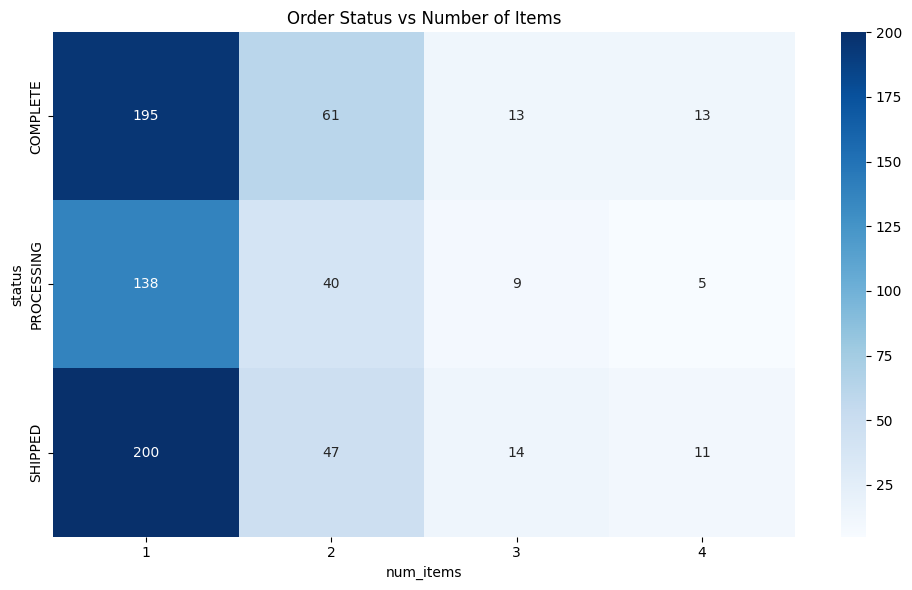

In [27]:
# Visual heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table.iloc[:-1, :-1], annot=True, fmt='d', cmap='Blues')
plt.title('Order Status vs Number of Items')
plt.tight_layout()
plt.show()

In [28]:
from scipy.stats import chi2_contingency

# Chi-square test: Are status and items related?
chi2, p_value, dof, expected = chi2_contingency(
    pd.crosstab(df['status'], df['num_items'])
)

print(f"\n📊 Statistical Test:")
print(f"Chi-square p-value: {p_value:.4f}")
print(f"Interpretation: {'RELATIONSHIP EXISTS' if p_value < 0.05 else 'NO SIGNIFICANT RELATIONSHIP'}")


📊 Statistical Test:
Chi-square p-value: 0.7922
Interpretation: NO SIGNIFICANT RELATIONSHIP


In [29]:
# second table
query_reject = """
select *
from `dbt-learn-80k.thelook.stg_orders_reject`
where MOD(order_id,100) = 1
limit  2000
"""

In [30]:
job_reject = client.query(query_reject)
rows_reject = [dict(row) for row in job_reject]
df_reject = pd.DataFrame(rows_reject)
print("✅ DataFrame created successfully!")
print(f"Shape: {df_reject.shape}")
print(f"Columns: {df_reject.columns.tolist()}")

✅ DataFrame created successfully!
Shape: (243, 9)
Columns: ['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at', 'shipped_at', 'delivered_at', 'num_of_item']


In [31]:
# PROPER DATA QUALITY CHECK FOR CATEGORICAL DATA
print("🔍 PROPER DATA QUALITY REPORT:")
print("=" * 50)

# 1. Basic info
print(f"1. Dataset Shape: {df_reject.shape}")

# 2. Categorical ID Analysis
print(f"\n2. ID Analysis (Categorical):")
print(f"   Unique order_ids: {df_reject['order_id'].nunique()} / {len(df_reject)} rows")
print(f"   Unique user_ids: {df_reject['user_id'].nunique()} / {len(df_reject)} rows")

# 3. Check for ID gaps or anomalies
print(f"\n3. ID Patterns:")
print(f"   order_id starts with: {df_reject['order_id'].iloc[0]}")
print(f"   Has sequential gaps: {'Yes' if (df_reject['order_id'].max() - df_reject['order_id'].min() + 1) != len(df) else 'No'}")

# 4. Data completeness
print(f"\n4. Data Completeness:")
print(f"   NULL values: {df_reject.isnull().sum().sum()} total")
for col in df_reject.columns:
    null_count = df_reject[col].isnull().sum()
    if null_count > 0:
        print(f"     {col}: {null_count} NULLs ({null_count/len(df_reject)*100:.1f}%)")

# 5. Business logic validation
print(f"\n5. Business Logic:")
print(f"   Status distribution:")
print(df_reject['status'].value_counts())
print(f"   Items per order: {df['num_items'].value_counts().to_dict()}")

🔍 PROPER DATA QUALITY REPORT:
1. Dataset Shape: (243, 9)

2. ID Analysis (Categorical):
   Unique order_ids: 243 / 243 rows
   Unique user_ids: 243 / 243 rows

3. ID Patterns:
   order_id starts with: 901
   Has sequential gaps: Yes

4. Data Completeness:
   NULL values: 471 total
     returned_at: 157 NULLs (64.6%)
     shipped_at: 157 NULLs (64.6%)
     delivered_at: 157 NULLs (64.6%)

5. Business Logic:
   Status distribution:
status
Cancelled    157
Returned      86
Name: count, dtype: int64
   Items per order: {1: 533, 2: 148, 3: 36, 4: 29}


In [34]:
df_accepted_clean = df.copy()
df_accepted_clean["status"] = df_accepted_clean["status"].str.upper().str.strip()
df_rejected_clean = df_reject.copy() 
df_rejected_clean['status'] = df_rejected_clean['status'].str.upper().str.strip()

In [35]:

print("🔄 CONVERTED TO UPPERCASE FOR CONSISTENT COMPARISON")
print("Accepted statuses:", df_accepted_clean['status'].unique().tolist())
print("Rejected statuses:", df_rejected_clean['status'].unique().tolist())

🔄 CONVERTED TO UPPERCASE FOR CONSISTENT COMPARISON
Accepted statuses: ['COMPLETE', 'PROCESSING', 'SHIPPED']
Rejected statuses: ['CANCELLED', 'RETURNED']


In [36]:
suspicious_rejects = df_rejected_clean[df_rejected_clean["status"].isin(['COMPLETE', 'PROCESSING', 'SHIPPED'])]
suspicious_rejects.isna().sum()

order_id        0
user_id         0
status          0
gender          0
created_at      0
returned_at     0
shipped_at      0
delivered_at    0
num_of_item     0
dtype: int64

In [38]:
# Comprehensive Business Analysis
print("📈 BUSINESS INTELLIGENCE ANALYSIS")
print("=" * 50)

# Get larger sample for robust analysis
query_business = """
SELECT *
FROM `dbt-learn-80k.thelook.stg_orders`
WHERE MOD(order_id, 100) = 1
LIMIT 2000
"""

job_business = client.query(query_business)
df_business = pd.DataFrame([dict(row) for row in job_business])

print(f"✅ Analyzing {len(df_business)} clean orders")
print(f"Date range: {df_business['order_date'].min()} to {df_business['order_date'].max()}")

📈 BUSINESS INTELLIGENCE ANALYSIS
✅ Analyzing 746 clean orders
Date range: 2023-01-02 to 2025-11-22


In [39]:
# Calculate core business metrics
print("\n💰 KEY BUSINESS METRICS:")
print("=" * 30)

total_orders = len(df_business)
unique_customers = df_business['user_id'].nunique()
avg_order_size = df_business['num_items'].mean()
completion_rate = (df_business['status'] == 'COMPLETE').sum() / total_orders * 100

print(f"Total Orders: {total_orders:,}")
print(f"Unique Customers: {unique_customers:,}")
print(f"Average Order Size: {avg_order_size:.1f} items")
print(f"Order Completion Rate: {completion_rate:.1f}%")

# Status distribution
print(f"\n📊 ORDER STATUS DISTRIBUTION:")
status_pct = df_business['status'].value_counts(normalize=True) * 100
for status, pct in status_pct.items():
    print(f"  {status}: {pct:.1f}%")


💰 KEY BUSINESS METRICS:
Total Orders: 746
Unique Customers: 746
Average Order Size: 1.4 items
Order Completion Rate: 37.8%

📊 ORDER STATUS DISTRIBUTION:
  COMPLETE: 37.8%
  SHIPPED: 36.5%
  PROCESSING: 25.7%


In [44]:
daily_orders = df_business.groupby('order_date').agg({
    'order_id': 'count',
    'user_id': 'nunique',
    'num_items': 'sum'
}).reset_index()

daily_orders.columns = ['date', 'daily_orders', 'daily_customers', 'total_items']
print(f"\n📅 DAILY TRENDS (Last {len(daily_orders)} days):")
print(f"Peak day: {daily_orders.loc[daily_orders['daily_orders'].idxmax(), 'date']}")
print(f"Average daily orders: {daily_orders['daily_orders'].mean():.1f}")


📅 DAILY TRENDS (Last 515 days):
Peak day: 2025-11-21
Average daily orders: 1.4


In [43]:
daily_orders

,order_date,order_id,user_id,num_items
0,2023-01-02,1,1,1
1,2023-01-06,2,2,2
2,2023-01-09,1,1,3
3,2023-01-14,1,1,2
4,2023-01-15,1,1,2
...,...,...,...,...
510,2025-11-18,6,6,6
511,2025-11-19,3,3,6
512,2025-11-20,8,8,10
513,2025-11-21,10,10,16


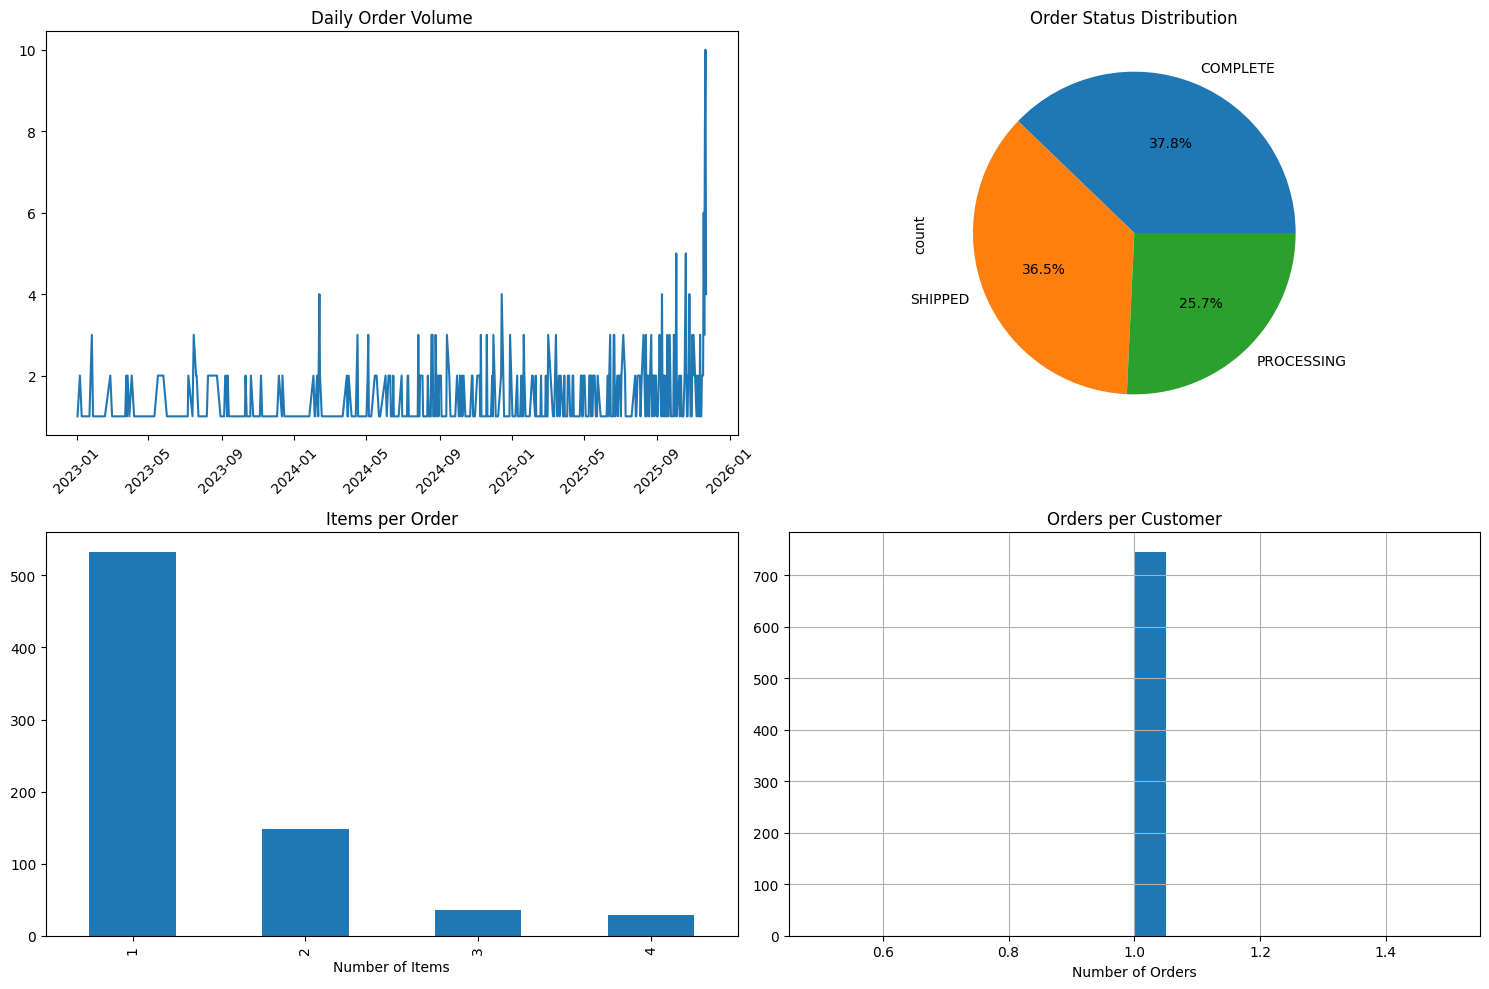

In [45]:
# Business insights visualization
plt.figure(figsize=(15, 10))

# Plot 1: Daily orders trend
plt.subplot(2, 2, 1)
plt.plot(daily_orders['date'], daily_orders['daily_orders'])
plt.title('Daily Order Volume')
plt.xticks(rotation=45)

# Plot 2: Status distribution
plt.subplot(2, 2, 2)
df_business['status'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Order Status Distribution')

# Plot 3: Order size distribution
plt.subplot(2, 2, 3)
df_business['num_items'].value_counts().sort_index().plot(kind='bar')
plt.title('Items per Order')
plt.xlabel('Number of Items')

# Plot 4: Customer order frequency
plt.subplot(2, 2, 4)
orders_per_customer = df_business['user_id'].value_counts()
orders_per_customer[orders_per_customer <= 5].hist(bins=20)
plt.title('Orders per Customer')
plt.xlabel('Number of Orders')

plt.tight_layout()
plt.show()

In [46]:
query_customers = """
select
user_id,
count(*) as total_orders,
SUM(num_items) as total_items,
MIN(order_date) as first_order,
MAX(order_date) as last_order,
FROM `dbt-learn-80k.thelook.stg_orders`
GRoup by user_id
"""

In [47]:
query_customers

'\nselect\nuser_id,\ncount(*) as total_orders,\nSUM(num_items) as total_items,\nMIN(order_date) as first_order,\nMAX(order_date) as last_order,\nFROM `dbt-learn-80k.thelook.stg_orders`\nGRoup by user_id\n'

In [48]:
job_customers = client.query(query_customers)

In [49]:
df_customers = pd.DataFrame([dict(rows) for rows in job_customers])

In [51]:
df_customers.head()

,user_id,total_orders,total_items,first_order,last_order
0,1951,3,9,2024-08-15,2025-09-10
1,5667,3,8,2024-03-01,2025-10-21
2,6420,2,8,2025-04-04,2025-08-04
3,8500,3,9,2025-10-02,2025-10-22
4,9587,4,9,2025-07-03,2025-11-03
